In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate,GridSearchCV
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from xgboost import XGBClassifier, plot_importance
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import shap
import pylab
import statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    StandardScaler,
)
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML
sns.set_style('whitegrid')

* We need to extract training data and prediction dataset and look at their descriptive statistics


 

In [2]:
df = pd.read_excel('recruiting_zeta-disease_training-data_take-home-challenge.xlsx')
pred = pd.read_excel('recruiting_zeta-disease_prediction-data_take-home-challenge.xlsx')
df.describe()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,30.985000,172.407500,32.201625,69.565000,85.887500,0.544496,43.121250,4.051250,0.348750
std,13.824025,31.942438,8.549155,19.874784,126.333656,0.348711,30.409949,4.176173,0.476873
min,18.000000,94.000000,0.000000,0.000000,0.000000,0.140800,0.000000,0.000000,0.000000
25%,21.000000,149.000000,27.300000,62.000000,0.000000,0.307800,0.000000,1.000000,0.000000
50%,26.000000,167.000000,32.050000,72.000000,45.000000,0.445300,53.000000,3.000000,0.000000
75%,38.000000,192.000000,36.525000,80.000000,130.000000,0.699800,62.000000,6.000000,1.000000
max,109.000000,308.000000,86.100000,157.000000,1077.000000,3.481300,214.000000,40.000000,1.000000


* Checking if there is any null value, there is no null values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 800 non-null    int64  
 1   weight              800 non-null    int64  
 2   bmi                 800 non-null    float64
 3   blood_pressure      800 non-null    int64  
 4   insulin_test        800 non-null    int64  
 5   liver_stress_test   800 non-null    float64
 6   cardio_stress_test  800 non-null    int64  
 7   years_smoking       800 non-null    int64  
 8   zeta_disease        800 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 56.4 KB


* Checking if this is an imbalanced dataset and it turns out yes, we have 35% of Zeta and 65% of no-Zeta.

In [4]:
df['zeta_disease'].value_counts()/(df['zeta_disease'].value_counts().sum())*100

zeta_disease
0    65.125
1    34.875
Name: count, dtype: float64

* look at correlation between features and the response

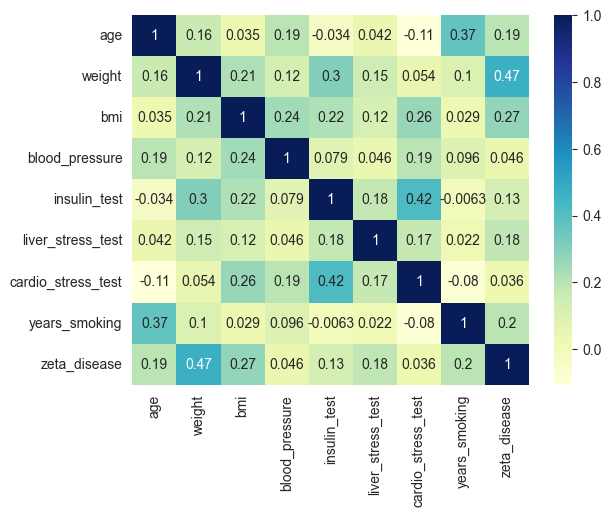

In [5]:
corr_plot = sns.heatmap(df.corr(), cmap='YlGnBu', annot=True)

* from the above heatmap, we see that weight and bmi are the top 2 features that correlate most with the response variable. Below I also tried to see the dist of the features in the dataset seeing if there is abnormality.

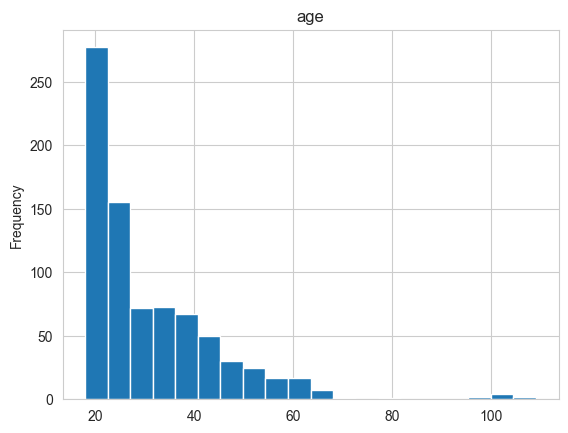

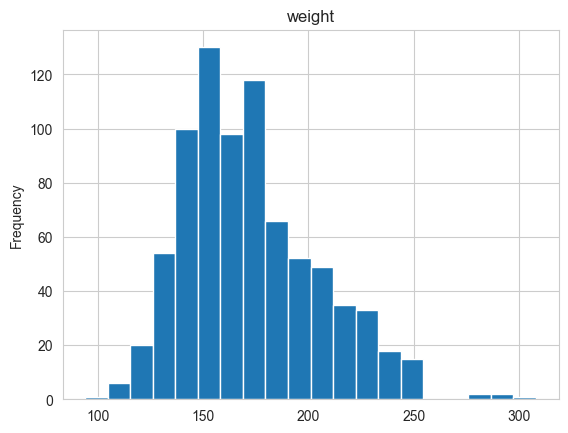

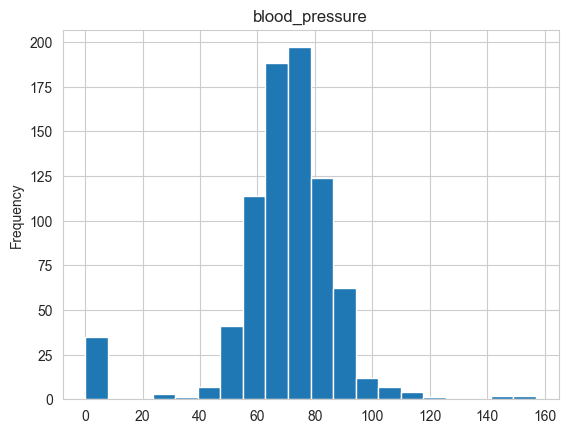

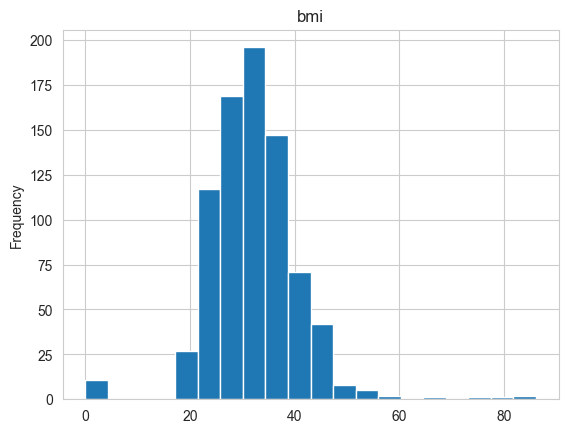

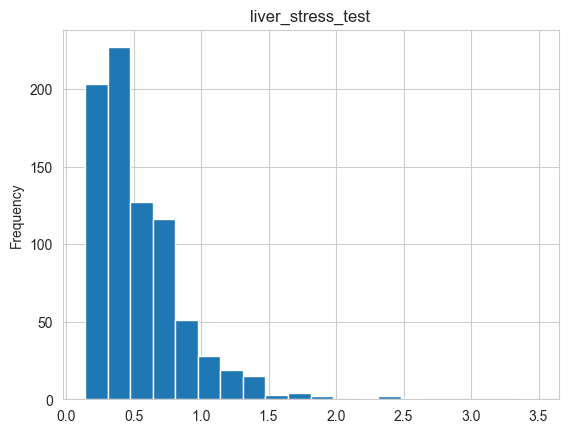

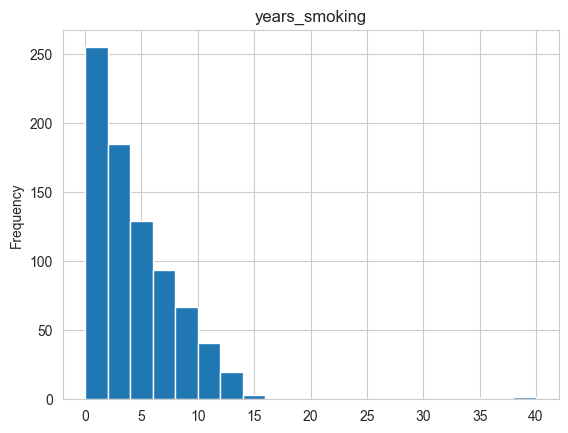

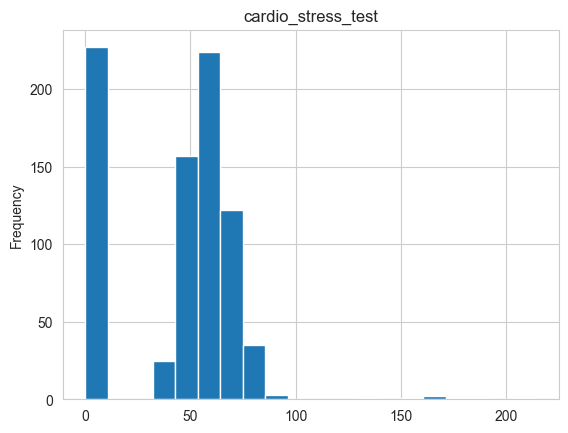

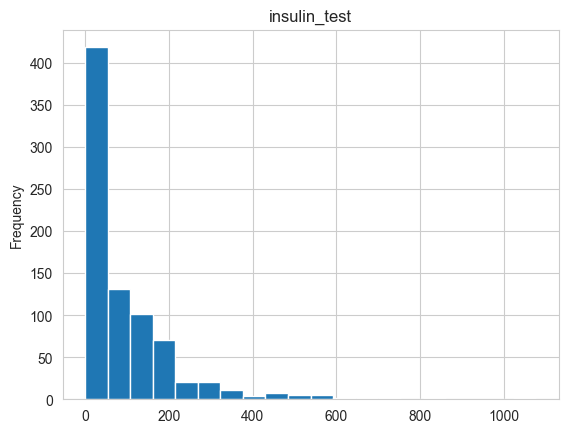

In [6]:
for feat in ['age', 'weight', 'blood_pressure','bmi', 'liver_stress_test', 'years_smoking', 'cardio_stress_test', 'insulin_test']:
    df[feat].plot(kind='hist', bins=20, title=feat)
    plt.show()


# Data Cleaning

* It turns out 35 of 800 (4.375%) instances shows 0 blood pressure and 11 of 800 (1.375%) shows 0 bmi. Both are not correct.

In [7]:
print('There are ' + str(df[df['bmi']==0].shape[0])+''' records of 0 bmi. This leads to a percentage of '''+ str(df[df['bmi']==0].shape[0]/df.shape[0]*100))
print('There are ' + str(df[df['blood_pressure']==0].shape[0])+''' records of 0 blood pressure. This leads to a percentage of '''+ str(df[df['blood_pressure']==0].shape[0]/df.shape[0]*100))
 

There are 11 records of 0 bmi. This leads to a percentage of 1.375
There are 35 records of 0 blood pressure. This leads to a percentage of 4.375


* it seems that we have relatively low percentage of 0 bmi, i chose to drop those rows.

In [8]:
df = df[df['bmi']!=0]

* Now, I want to focus on the blood pressure, which is highly correlated with bmi. So the plan here is to extract information from the bmi to populate those zero blood pressure cases.


In [9]:
# we look at the percentile of our bmi value after filtering
print(np.percentile(df['bmi'], [0, 25, 50, 75, 100]))

[18.2 27.5 32.4 36.6 86.1]


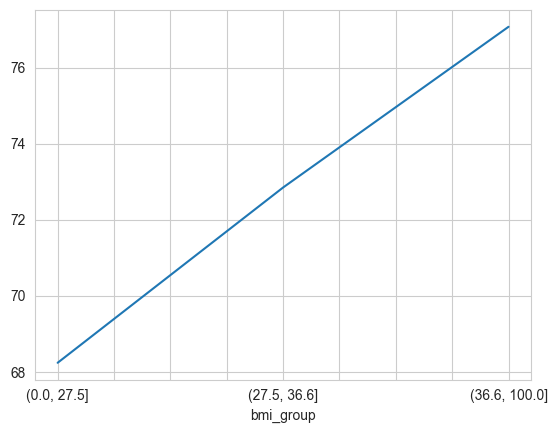

In [10]:
# we create bmi groups based on the percentile listed above 
df['bmi_group'] = pd.cut(df['bmi'], bins=[0, 27.5, 36.6, 100])

# we want to see by taking out the weird values of blood pressure, is there  a trend for different age groups?
df[df['blood_pressure']!=0].groupby(['bmi_group'])['blood_pressure'].mean().plot(kind='line')
plt.show()

# from the plot, we see that a higher bmi group leads to higher pressure which makes sense.
# and i can create a dictionary to patch those with 0 blood pressure to have a reasonable value.
blood_pressure_dic = df[df['blood_pressure']!=0].groupby(['bmi_group'])['blood_pressure'].mean().to_dict()
df['blood_pressure'] = np.where(df['blood_pressure']==0, df['bmi_group'].map(blood_pressure_dic), df['blood_pressure'])

# for model training purposes (avoid column names mixup), we will drop the column now
df = df.drop('bmi_group', axis=1)

* also from the distribution, i see under cardio test, there are lots of zeros. I would have assumed this feature would show normality given the nature of the test (majority of the people should be in the middle). By looking at the non-zero cardio test values, the mean is around 60. Those 0, could come from lack of data by guessing, and I have decided to move those 0 to the mean of the cardio test.

In [11]:
df[df['cardio_stress_test']!=0]['cardio_stress_test'].mean()

60.229422066549915

In [12]:
df['cardio_stress_test'] = np.where(df['cardio_stress_test']==0, 60.23, df['cardio_stress_test'])

# Model Building and Transformation

* First, we need to apply standardization to the features to help us analyze the influence of each feature

In [13]:
train_feature = df.iloc[:, :-1]
train_response = df.iloc[:, -1]

* we first can split our training dataset into train and test dataset.

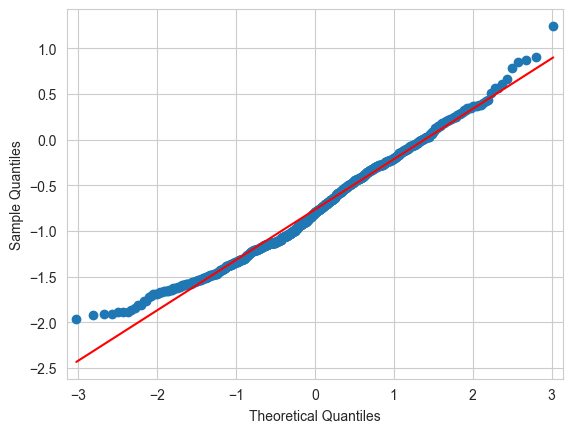

In [14]:
# from the qq plot, i can see that by taking the log of liver stress test
# i can get a rather good normal dist
test = np.log(train_feature['liver_stress_test'].values)
sm.qqplot(test, line='s')
pylab.show()


* splitting dataset and performing data transformation

In [15]:

random_seed = 20
X_train, X_test, y_train, y_test = train_test_split(train_feature, train_response, test_size=0.33, random_state=random_seed, stratify=train_response)
column_trans = ColumnTransformer(
    [
        (
            "Log-Transform",
            FunctionTransformer(func=np.log),
            ["liver_stress_test"],
        ),
        (
            "Standardize",
            StandardScaler(),
            ["weight", "bmi", "blood_pressure", "cardio_stress_test"],
        ),
        
        (
            "MinMax",
            MinMaxScaler(),
            ['insulin_test', 'age', 'years_smoking'],
        ),        
    
    ],
)
X_train_scaled = column_trans.fit_transform(X_train)
X_test_scaled = column_trans.transform(X_test)

In [16]:
tx = column_trans.get_params()['transformers']
feature_names = []
for name,transformer,features in tx:
    try:
        Var = column_trans.named_transformers_[name].get_feature_names().tolist()
    except AttributeError:
        Var = features
    feature_names = feature_names + Var

In [17]:
feature_names

['liver_stress_test',
 'weight',
 'bmi',
 'blood_pressure',
 'cardio_stress_test',
 'insulin_test',
 'age',
 'years_smoking']

* Strategy is to use gridsearch cv to go through several models (Logistic regression/balanced random forest/xgbclassifier) and find the best one 

* Logistic Regression

In [18]:
grid={"C":np.logspace(-4,4,9)} # specifying the parameter grid search space
logreg=LogisticRegression(random_state=random_seed, class_weight='balanced')
logreg_cv=GridSearchCV(logreg,grid,cv=10, scoring='roc_auc')
logreg_cv.fit(X_train_scaled,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("roc_auc :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0}
roc_auc : 0.8120052582436484


* Balanced random forest classifier from imblearn

In [19]:
grid={"n_estimators":[200, 100, 50, 25], "max_depth":[3, 5, 10, 20], "criterion":['gini', 'entropy']}# l1 lasso l2 ridge
brf = BalancedRandomForestClassifier(random_state=random_seed)
brf_cv=GridSearchCV(brf,grid,cv=10, scoring='roc_auc')
brf_cv.fit(X_train_scaled,y_train)



GridSearchCV(cv=10, estimator=BalancedRandomForestClassifier(random_state=20),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, 20],
                         'n_estimators': [200, 100, 50, 25]},
             scoring='roc_auc')

In [20]:
print("tuned hpyerparameters :(best parameters) ",brf_cv.best_params_)
print("roc_auc :",brf_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 200}
roc_auc : 0.8203404344193819


* XGB Classifier

In [21]:
grid={"n_estimators":[10, 20, 40], "max_depth":[3, 5, 10], "learning_rate":[0.05, 0.1, 0.2, 0.3]}# n_estimators=10, max_depth=3, learning_rate=0.2
xgbc = XGBClassifier(scale_pos_weight = 65/35, random_state=random_seed)
xgbc_cv=GridSearchCV(xgbc,grid,cv=10, scoring='roc_auc')
xgbc_cv.fit(X_train_scaled,y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=20, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [10, 20, 40]},
             scoring='roc_auc')

In [22]:
print("tuned hpyerparameters :(best parameters) ",xgbc_cv.best_params_)
print("roc_auc score:",xgbc_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 40}
roc_auc score: 0.8133063049781315


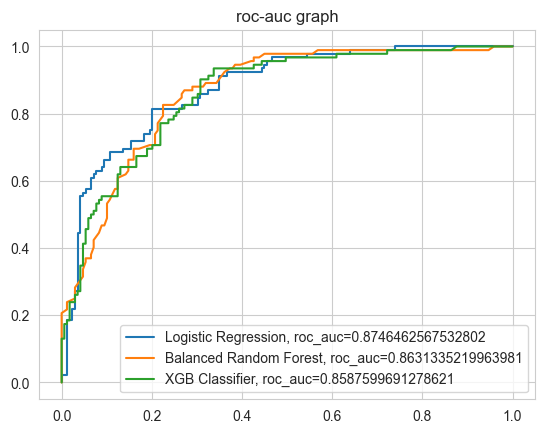

In [23]:
models=[logreg_cv, brf_cv, xgbc_cv]

for model in models:    
    model_dic={logreg_cv: 'Logistic Regression', xgbc_cv:'XGB Classifier', brf_cv:'Balanced Random Forest'}
    y_pred_proba = model.predict_proba(X_test_scaled)[:, -1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr, label=str(model_dic[model])+", roc_auc="+str(auc))
    plt.title("roc-auc graph")
    plt.legend(loc=4)

* it looks like Logistic Regression has the best roc_auc. Logistic Regression is the winner.

# Model Explanability

* From shapley values shown below, we see that weight/bmi/liver stress test/years smoking/age are top 5 features that drive the final prediction. Higher values of these five features lead to higher chances of getting Zeta.

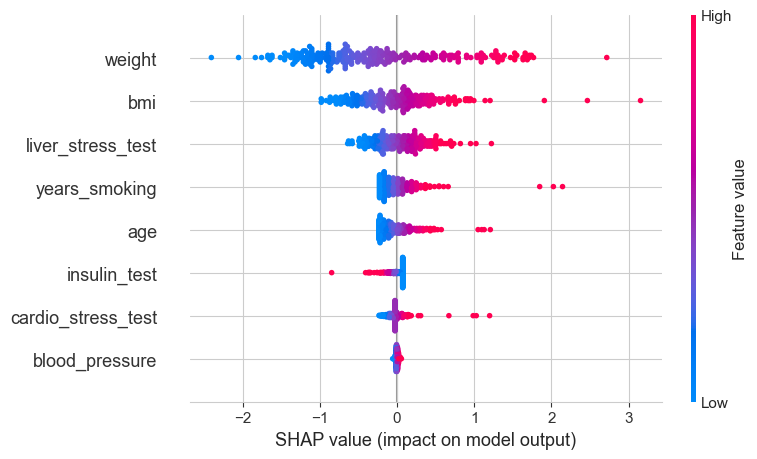

In [24]:
shap.initjs()
explainer = shap.Explainer(
    logreg_cv.best_estimator_, X_test_scaled, feature_names=feature_names
)
eval_df = pd.DataFrame(X_test_scaled, columns = feature_names)
shap_values = explainer.shap_values(eval_df)
shap.summary_plot(shap_values, eval_df, plot_type='dot')


# Predictions on 20 Records

In [25]:
# check if we need to correct feature value as we did in the training dataset
pred.describe()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,0.0
mean,34.750000,178.800000,34.480000,78.500000,145.050000,1.569600,61.950000,6.050000,NaN
std,11.511436,27.935264,6.628773,14.005638,75.964309,0.230356,9.703363,3.471311,NaN
min,19.000000,120.000000,25.800000,59.000000,50.000000,1.249800,43.000000,2.000000,NaN
25%,26.250000,153.250000,30.250000,69.750000,76.250000,1.411800,55.750000,3.000000,NaN
50%,34.500000,188.500000,33.150000,72.500000,137.000000,1.483300,60.000000,5.500000,NaN
75%,44.250000,197.750000,37.600000,89.250000,167.750000,1.737800,68.000000,7.500000,NaN
max,60.000000,216.000000,50.700000,108.000000,362.000000,2.050800,83.000000,13.000000,NaN


* from the above statistics, we don't see a problem with 0-blood_pressure, 0-bmi, or 0-cardio-stress-test

In [26]:
X_pred = column_trans.transform(pred[df.columns[:-1]])
X_pred = pd.DataFrame(X_pred, columns=df.columns[:-1])
X_pred['zeta_disease'] = logreg_cv.predict(X_pred)

* export the final result to a excel spreadsheet

In [27]:
final_result = pd.concat([pred.iloc[:, :-1], X_pred['zeta_disease']], axis=1)

In [28]:
final_result

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,24,151,39.5,69,72,1.3968,56,4,1
1,27,179,35.5,89,156,1.6608,43,6,1
2,34,147,26.9,76,74,1.6958,53,2,0
3,35,206,32.4,73,127,1.4608,61,6,1
4,60,193,29.8,62,192,1.7798,65,9,1
5,45,120,36.5,108,50,1.2978,54,12,1
6,20,139,38.2,61,77,1.5818,68,3,0
7,23,137,31.2,70,73,1.4168,59,7,0
8,36,195,30.5,59,141,1.4498,59,6,1
9,19,193,25.8,84,66,1.7938,50,3,1


In [29]:
final_result.to_excel('submission.xlsx', index=False)